# Libraries

In [ ]:
#pip install tsfel



In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from scipy import signal
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, SelectPercentile
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import scipy.io as sio
# import neurokit2 as nk
import seaborn as sns

import pandas as pd
import numpy as np
import time
import heartpy as hp
import tsfel 
import ast
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal as signal
import tsfel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


pd.options.display.max_colwidth = 999_999_999
pd.options.display.max_columns = 5000

# Preprocessing

In [2]:
def merge_weak_and_strong (file_1, file_2):

    '''
    Function reads two dataframe (ecg signal of weak and string emotion)

    Returns single dataframe with combining both ecg signlas with label (strong or weak)
    '''

    df_1 = pd.read_csv(file_1)
    df_2 = pd.read_csv(file_2)

    df_1[['label']] = 'strong'  #groundtruth for strong emotion
    df_2[['label']] = 'weak'    #groundtruth for weak emotion

    #combining two dataframes ontop of each other
    df_combined = pd.concat([df_1, df_2], axis=0, ignore_index=True)
    df_combined.drop(['Unnamed: 0'], axis=1, inplace=True)
    df_combined.drop([41], inplace=True)
    df_combined.reset_index(inplace=True)

    return df_combined


In [3]:
def access_ecgsignal(ecg):

    '''
    Function access the ecg signals (waveform samples) wrapped in a list

    '''

    try:
        if '[' in ecg:    # checking if it is a list, for some reason can't do or ']', because ints return as a list
            retList = [int(x) if x.isdigit() else str(x) for x in ecg.strip('[]').split(' ')]
            return retList
        if ecg=='True':
            return True
        elif ecg=='False':
            return False
        return int(ecg)
    except:
        return ecg

## Implement merging and access ECG signals

In [5]:
df = merge_weak_and_strong('df_dataset.csv','df_dataset_2.csv')  # merge ecg signal of weak and strong emotions

array_ = []

for i in range(86):
    waveform_samples =  df.waveform_samples[i] #read waveform sample column 
    waveform_sample = access_ecgsignal(waveform_samples) #access waveform sample using defined function access_ecgsignal
    waveform_sample = pd.to_numeric(waveform_sample, errors='coerce')
    waveform_sample = np.array(waveform_sample) #converts ndarray to array
    waveform_sample_ = waveform_sample[~np.isnan(waveform_sample)] #removes nan from numpy array
    array_.append(waveform_sample_)  #append to an array

array_



[array([32767., 32767., 32767., ...,  1522.,   944.,   112.]),
 array([-7867., -7947., -7922., ...,  1667.,  1309.,   759.]),
 array([32767., 32767., 32767., ...,  -725.,  -414.,   -78.]),
 array([32767., 32767., 32767., ...,   148.,    58.,     0.]),
 array([32767., 32767., 32767., ...,  -374.,  -255.,  -141.]),
 array([-7291., -7311., -7311., ...,  -316.,  -210.,   -42.]),
 array([-6452., -6464., -6471., ...,    28.,    11.,     0.]),
 array([3.2767e+04, 3.2767e+04, 3.2767e+04, ..., 3.5000e+01, 1.4000e+01,
        0.0000e+00]),
 array([32767., 32767., 32767., ...,  -424.,  -266.,     0.]),
 array([3.2767e+04, 3.2767e+04, 3.2767e+04, ..., 1.4000e+01, 1.2000e+01,
        0.0000e+00]),
 array([32767., 32767., 32767., ...,  -807.,  -599.,  -292.]),
 array([-7897., -8027., -8143., ...,  -882.,  -751.,  -631.]),
 array([32767., 32767., 32767., ...,   351.,   208.,     0.]),
 array([32767., 32767., 32767., ...,  -927.,  -841.,  -785.]),
 array([-7441., -7770., -7920., ...,  6071.,  6143.,  

# Fast Fourier Transform - Filter signals

In [9]:
y_list = []
x_list = []
yf_list = []
xf_list = []

for i in range(len(array_)):

    #convert array to double list and access the first element
    y = [array_[i].tolist()]
    y = y[0]    
    y_list.append(y)

    n = len(y) #number of sample points
    # Sample spacing
    fs = 1000
    t = 1.0/fs

    # x-axis
    x = np.linspace(0.0, n*t, n)
    x_list.append(x)

    #Apply fourier transform to waveform transform
    yf = scipy.fftpack.fft(y)
    yf_list.append(yf)

    #compute frequency of x-axis
    xf = np.linspace(0.0, 1.0/(2.0*t), int(n/2))
    xf_list.append(xf)

    filtered_signals = []
 

for x,y in zip(x_list,y_list):


    b, a = signal.butter(4, 50/(fs/2), 'low') #compute filtering co-efficients

    #compute filtered signals
    tempf = signal.filtfilt(b,a, y)
    #b, a = signal.butter(1, band_filt/(Fs/2), 'bandstop')
    tempf = signal.filtfilt(b,a, y)
    yff = scipy.fftpack.fft(tempf)

    #Compute Kaiser Window Coefficient to creatae a lowpass FIR filter
    nyq_rate = fs/ 2.0
    # The desired width of the transition from pass to stop.
    width = 5.0/nyq_rate
    # The desired attenuation in the stop band, in dB.
    ripple_db = 60.0
    # Compute the order and Kaiser parameter for the FIR filter.
    O, beta = signal.kaiserord(ripple_db, width)
    # The cutoff frequency of the filter.
    cutoff_hz = 4.0


    ###Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = signal.firwin(O, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
    # Use lfilter to filter x with the FIR filter.
    y_filt = signal.lfilter(taps, 1.0, tempf)
    filtered_signals.append(y_filt)
    yff = scipy.fftpack.fft(y_filt)


# Feature extraction using filtered signals

In [25]:
cfg = tsfel.get_features_by_domain()

def extract_features (extractor, signal, sampling_rate):

    '''
    Function uses TSFEL package to extract features from filtered ECG signals
     
    '''

    features = tsfel.time_series_features_extractor(extractor,signal, fs=sampling_rate)
    features['label'] = df.label  #joining the label for each signals
    features['label_encoded'] = LabelEncoder().fit_transform(features.label)
    features = features.sample(frac=1)
    return features

## Implementing feature extraction 

In [26]:
df_ml_dataset = extract_features(extractor=cfg, signal=filtered_signals, sampling_rate=256)
df_ml_dataset

*** Feature extraction started ***


/opt/homebrew/lib/python3.9/site-packages/tsfel/feature_extraction/calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
/opt/homebrew/lib/python3.9/site-packages/tsfel/feature_extraction/calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
/opt/homebrew/lib/python3.9/site-packages/tsfel/feature_extraction/calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_final = features_final.append(feat)
/opt/homebrew/lib/python3.9/site-packages/tsfel/feature_extraction/calc_features.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version


*** Feature extraction finished ***


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_11,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_12,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_13,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_14,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_147,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_15,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT mean coefficient_152,0_FFT mean coefficient_153,0_FFT mean coefficient_154,0_FFT mean coefficient_155,0_FFT mean coefficient_156,0_FFT mean coefficient_157,0_FFT mean coefficient_158,0_FFT mean coefficient_159,0_FFT mean coefficient_16,0_FFT mean coefficient_160,0_FFT mean coefficient_161,0_FFT mean coefficient_162,0_FFT mean coefficient_163,0_FFT mean coefficient_164,0_FFT mean coefficient_165,0_FFT mean coefficient_166,0_FFT mean coefficient_167,0_FFT mean coefficient_168,0_FFT mean coefficient_169,0_FFT mean coefficient_17,0_FFT mean coefficient_170,0_FFT mean coefficient_171,0_FFT mean coefficient_172,0_FFT mean coefficient_173,0_FFT mean coefficient_174,0_FFT mean coefficient_175,0_FFT mean coefficient_176,0_FFT mean coefficient_177,0_FFT mean coefficient_178,0_FFT mean coefficient_179,0_FFT mean coefficient_18,0_FFT mean coefficient_180,0_FFT mean coefficient_181,0_FFT mean coefficient_182,0_FFT mean coefficient_183,0_FFT mean coefficient_184,0_FFT mean coefficient_185,0_FFT mean coefficient_186,0_FFT mean coefficient_187,0_FFT mean coefficient_188,0_FFT mean coefficient_189,0_FFT mean coefficient_19,0_FFT mean coefficient_190,0_FFT mean coefficient_191,0_FFT mean coefficient_192,0_FFT mean coefficient_193,0_FFT mean coefficient_194,0_FFT mean coefficient_195,0_FFT mean coefficient_196,0_FFT mean coefficient_197,0_FFT mean coefficient_198,0_FFT mean coefficient_199,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_200,0_FFT mean coefficient_201,0_FFT mean coefficient_202,0_FFT mean coefficient_203,0_FFT mean coefficient_204,0_FFT mean coefficient_205,0_FFT mean coefficient_206,0_FFT mean coefficient_207,0_FFT mean coefficient_208,0_FFT mean coefficient_209,0_FFT mean coefficient_21,0_FFT mean coefficient_210,0_FFT mean coefficient_211,0_FFT mean coefficient_212,0_FFT mean coefficient_213,0_FFT mean coefficient_214,0_FFT mean coefficient_215,0_FFT mean coefficient_216,0_FFT mean coefficient_217,0_FFT mean coefficient_218,0_FFT mean coefficient_219,0_FFT mean coefficient_22,0_FFT mean coefficient_220,0_FFT mean coefficient_221,0_FFT mean coefficient_222,0_F

# Model Training

In [48]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)
X_train

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_11,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_12,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_13,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_14,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_147,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_15,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT mean coefficient_152,0_FFT mean coefficient_153,0_FFT mean coefficient_154,0_FFT mean coefficient_155,0_FFT mean coefficient_156,0_FFT mean coefficient_157,0_FFT mean coefficient_158,0_FFT mean coefficient_159,0_FFT mean coefficient_16,0_FFT mean coefficient_160,0_FFT mean coefficient_161,0_FFT mean coefficient_162,0_FFT mean coefficient_163,0_FFT mean coefficient_164,0_FFT mean coefficient_165,0_FFT mean coefficient_166,0_FFT mean coefficient_167,0_FFT mean coefficient_168,0_FFT mean coefficient_169,0_FFT mean coefficient_17,0_FFT mean coefficient_170,0_FFT mean coefficient_171,0_FFT mean coefficient_172,0_FFT mean coefficient_173,0_FFT mean coefficient_174,0_FFT mean coefficient_175,0_FFT mean coefficient_176,0_FFT mean coefficient_177,0_FFT mean coefficient_178,0_FFT mean coefficient_179,0_FFT mean coefficient_18,0_FFT mean coefficient_180,0_FFT mean coefficient_181,0_FFT mean coefficient_182,0_FFT mean coefficient_183,0_FFT mean coefficient_184,0_FFT mean coefficient_185,0_FFT mean coefficient_186,0_FFT mean coefficient_187,0_FFT mean coefficient_188,0_FFT mean coefficient_189,0_FFT mean coefficient_19,0_FFT mean coefficient_190,0_FFT mean coefficient_191,0_FFT mean coefficient_192,0_FFT mean coefficient_193,0_FFT mean coefficient_194,0_FFT mean coefficient_195,0_FFT mean coefficient_196,0_FFT mean coefficient_197,0_FFT mean coefficient_198,0_FFT mean coefficient_199,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_200,0_FFT mean coefficient_201,0_FFT mean coefficient_202,0_FFT mean coefficient_203,0_FFT mean coefficient_204,0_FFT mean coefficient_205,0_FFT mean coefficient_206,0_FFT mean coefficient_207,0_FFT mean coefficient_208,0_FFT mean coefficient_209,0_FFT mean coefficient_21,0_FFT mean coefficient_210,0_FFT mean coefficient_211,0_FFT mean coefficient_212,0_FFT mean coefficient_213,0_FFT mean coefficient_214,0_FFT mean coefficient_215,0_FFT mean coefficient_216,0_FFT mean coefficient_217,0_FFT mean coefficient_218,0_FFT mean coefficient_219,0_FFT mean coefficient_22,0_FFT mean coefficient_220,0_FFT mean coefficient_221,0_FFT mean coefficient_222,0_F

## Feature Selection

In [30]:

model_XGB = XGBClassifier()
model_RAN = RandomForestClassifier()
model_ADA = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

num_of_feature = [5,10,15]

for num in num_of_feature:

    rfe_XGB = RFE(estimator=model_XGB, n_features_to_select=num)
    rfe_RAN = RFE(estimator=model_RAN, n_features_to_select=num)
    rfe_ADA = RFE(estimator=model_ADA, n_features_to_select=num)


    rfe_XGB.fit(X_train, y_train.values.ravel())
    rfe_XGB_features = X_train.columns[rfe_XGB.support_]
    print(f"===== {len(rfe_XGB_features)} XGB features were selected =====")
    print(f"{', '.join(rfe_XGB_features)}")


    rfe_RAN.fit(X_train, y_train.values.ravel())
    rfe_RAN_features = X_train.columns[rfe_RAN.support_]
    print(f"===== {len(rfe_RAN_features)} RAN features were selected =====")
    print(f"{', '.join(rfe_RAN_features)}")

    rfe_ADA.fit(X_train, y_train.values.ravel())
    rfe_ADA_features = X_train.columns[rfe_ADA.support_]
    print(f"===== {len(rfe_ADA_features)} ADA features were selected =====")
    print(f"{', '.join(rfe_ADA_features)}")


===== 5 XGB features were selected =====
0_FFT mean coefficient_0, 0_FFT mean coefficient_28, 0_Kurtosis, 0_LPCC_1, 0_Median diff
===== 5 RAN features were selected =====
0_FFT mean coefficient_18, 0_LPCC_0, 0_Median absolute diff, 0_Median diff, 0_Zero crossing rate
===== 5 ADA features were selected =====
0_FFT mean coefficient_0, 0_FFT mean coefficient_45, 0_LPCC_8, 0_Median diff, 0_Spectral entropy
===== 10 XGB features were selected =====
0_FFT mean coefficient_0, 0_FFT mean coefficient_28, 0_FFT mean coefficient_37, 0_FFT mean coefficient_46, 0_Kurtosis, 0_LPCC_1, 0_Median absolute diff, 0_Median diff, 0_Wavelet absolute mean_5, 0_Zero crossing rate
===== 10 RAN features were selected =====
0_FFT mean coefficient_10, 0_FFT mean coefficient_18, 0_FFT mean coefficient_28, 0_LPCC_0, 0_LPCC_9, 0_Median absolute diff, 0_Median diff, 0_Signal distance, 0_Sum absolute diff, 0_Zero crossing rate
===== 10 ADA features were selected =====
0_FFT mean coefficient_0, 0_FFT mean coefficient_45

### KFold with feature selection and Grid search CV

In [12]:
X = features.drop(['label','label_encoded'],axis=1)
y = features[['label_encoded']]

X_train,X_test,y_train, y_test= train_test_split(X,y,random_state=3,test_size=0.2,shuffle=True )

#### XGBOOST

5 Features

In [50]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_11,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_12,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_13,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_14,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_147,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_15,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT mean coefficient_152,0_FFT mean coefficient_153,0_FFT mean coefficient_154,0_FFT mean coefficient_155,0_FFT mean coefficient_156,0_FFT mean coefficient_157,0_FFT mean coefficient_158,0_FFT mean coefficient_159,0_FFT mean coefficient_16,0_FFT mean coefficient_160,0_FFT mean coefficient_161,0_FFT mean coefficient_162,0_FFT mean coefficient_163,0_FFT mean coefficient_164,0_FFT mean coefficient_165,0_FFT mean coefficient_166,0_FFT mean coefficient_167,0_FFT mean coefficient_168,0_FFT mean coefficient_169,0_FFT mean coefficient_17,0_FFT mean coefficient_170,0_FFT mean coefficient_171,0_FFT mean coefficient_172,0_FFT mean coefficient_173,0_FFT mean coefficient_174,0_FFT mean coefficient_175,0_FFT mean coefficient_176,0_FFT mean coefficient_177,0_FFT mean coefficient_178,0_FFT mean coefficient_179,0_FFT mean coefficient_18,0_FFT mean coefficient_180,0_FFT mean coefficient_181,0_FFT mean coefficient_182,0_FFT mean coefficient_183,0_FFT mean coefficient_184,0_FFT mean coefficient_185,0_FFT mean coefficient_186,0_FFT mean coefficient_187,0_FFT mean coefficient_188,0_FFT mean coefficient_189,0_FFT mean coefficient_19,0_FFT mean coefficient_190,0_FFT mean coefficient_191,0_FFT mean coefficient_192,0_FFT mean coefficient_193,0_FFT mean coefficient_194,0_FFT mean coefficient_195,0_FFT mean coefficient_196,0_FFT mean coefficient_197,0_FFT mean coefficient_198,0_FFT mean coefficient_199,0_FFT mean coefficient_2,0_FFT mean coefficient_20,0_FFT mean coefficient_200,0_FFT mean coefficient_201,0_FFT mean coefficient_202,0_FFT mean coefficient_203,0_FFT mean coefficient_204,0_FFT mean coefficient_205,0_FFT mean coefficient_206,0_FFT mean coefficient_207,0_FFT mean coefficient_208,0_FFT mean coefficient_209,0_FFT mean coefficient_21,0_FFT mean coefficient_210,0_FFT mean coefficient_211,0_FFT mean coefficient_212,0_FFT mean coefficient_213,0_FFT mean coefficient_214,0_FFT mean coefficient_215,0_FFT mean coefficient_216,0_FFT mean coefficient_217,0_FFT mean coefficient_218,0_FFT mean coefficient_219,0_FFT mean coefficient_22,0_FFT mean coefficient_220,0_FFT mean coefficient_221,0_FFT mean coefficient_222,0_F

Training & Validation Results
Accuracy: 0.869047619047619
Precision 0.8966666666666667
recall 0.8416666666666666
f1 0.826984126984127
Test Results
XGBost Real result:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


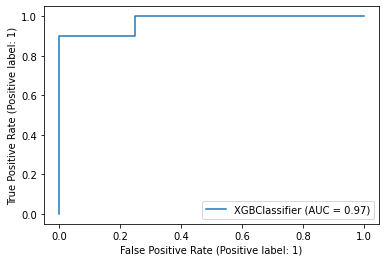

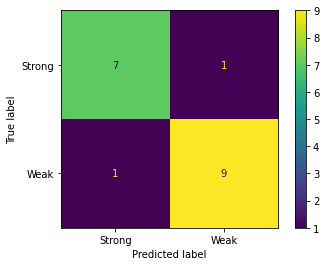

In [51]:
#Instantiate a baseline model
xgb.set_config(verbosity=0)
model_XGB = XGBClassifier(silent=True)

#Feature Selection
model_XGB_rfe = RFE(model_XGB, n_features_to_select=5)
model_XGB_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
XGB_extracted_features = X_train.columns[model_XGB_rfe.support_]

#Obtain optimised hyperparameters
param_grid_XGB =  {
        'gamma': [0.2, 0.4, 0.6],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimator':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001] }

XGB_optimised = GridSearchCV(model_XGB, param_grid=param_grid_XGB,scoring='accuracy', cv=10)
XGB_optimised.fit(X_train, y_train.values.ravel())
model_XGB_optimised = XGB_optimised.best_estimator_

#Validation with optimised model
kf = KFold(n_splits=10, shuffle=True)
acc_score = []
precision_score_xgb = []
recall_score_xgb = []
f1_score_xgb = []

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_XGB_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_XGB_optimised.predict(X_val)
        
        acc = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score.append(acc)
        precision_score_xgb.append(precision)
        recall_score_xgb.append(recall)
        f1_score_xgb.append(f1)

print('Accuracy:', np.mean(acc_score))
print('Precision', np.mean(precision_score_xgb))
print('recall', np.mean(recall_score_xgb))
print('f1',np.mean( f1_score_xgb))

#Evaluation on Test set
print ('Test Results')
pred_test = model_XGB_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('XGBost Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_roc_curve(model_XGB_optimised, X_test, y_test)
plot_confusion_matrix(model_XGB_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

10 Features

In [52]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results
Accuracy: 0.8523809523809524
Precision 0.875
recall 0.8400000000000001
f1 0.8238455988455987
Test Results
XGBost Real result:  0.9444444444444444
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


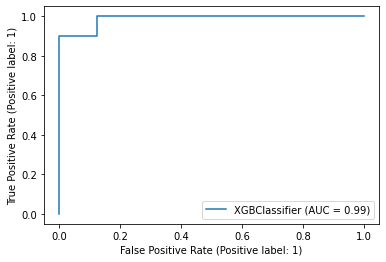

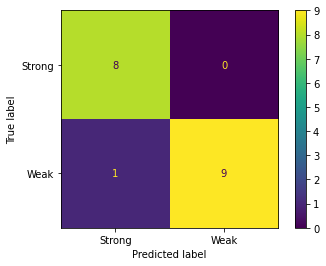

In [53]:
xgb.set_config(verbosity=0)
model_XGB = XGBClassifier(silent=True)

#train a baseline model

model_XGB_rfe = RFE(model_XGB, n_features_to_select=10)
model_XGB_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
XGB_extracted_features = X_train.columns[model_XGB_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
param_grid_XGB =  {
        'gamma': [0.2, 0.4, 0.6],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimator':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001] }

XGB_optimised = GridSearchCV(model_XGB, param_grid=param_grid_XGB,scoring='accuracy', cv=10)
XGB_optimised.fit(X_train, y_train.values.ravel())
model_XGB_optimised = XGB_optimised.best_estimator_


#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score = []
precision_score_xgb = []
recall_score_xgb = []
f1_score_xgb = []

# X = features.drop(['label','label_encoded'],axis=1)
# X = X[XGB_extracted_features]
# y = features[['label_encoded']]
# X_train,X_test,y_train, y_test= train_test_split(X,y,random_state=3,test_size=0.2,shuffle=True )
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_XGB_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_XGB_optimised.predict(X_val)
        
        acc = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score.append(acc)
        precision_score_xgb.append(precision)
        recall_score_xgb.append(recall)
        f1_score_xgb.append(f1)


print('Accuracy:', np.mean(acc_score))
print('Precision', np.mean(precision_score_xgb))
print('recall', np.mean(recall_score_xgb))
print('f1',np.mean( f1_score_xgb))


print ('Test Results')
pred_test = model_XGB_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('XGBost Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_roc_curve(model_XGB_optimised, X_test, y_test)
plot_confusion_matrix(model_XGB_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

15 Features

In [54]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results
Accuracy: 0.8523809523809524
Precision 0.8716666666666667
recall 0.8266666666666665
f1 0.8412698412698413
Test Results
XGBost Real result:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


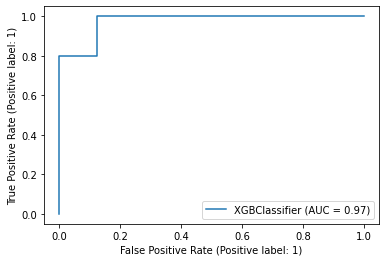

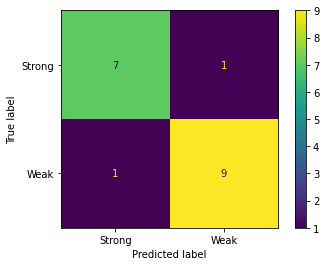

In [55]:
xgb.set_config(verbosity=0)
model_XGB = XGBClassifier(silent=True)

#train a baseline model

model_XGB_rfe = RFE(model_XGB, n_features_to_select=15)
model_XGB_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
XGB_extracted_features = X_train.columns[model_XGB_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
param_grid_XGB =  {
        'gamma': [0.2, 0.4, 0.6],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimator':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001] }

XGB_optimised = GridSearchCV(model_XGB, param_grid=param_grid_XGB,scoring='accuracy', cv=10)
XGB_optimised.fit(X_train, y_train.values.ravel())
model_XGB_optimised = XGB_optimised.best_estimator_


#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score = []
precision_score_xgb = []
recall_score_xgb = []
f1_score_xgb = []

# X = features.drop(['label','label_encoded'],axis=1)
# X = X[XGB_extracted_features]
# y = features[['label_encoded']]
# X_train,X_test,y_train, y_test= train_test_split(X,y,random_state=3,test_size=0.2,shuffle=True )
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_XGB_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_XGB_optimised.predict(X_val)
        
        acc = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score.append(acc)
        precision_score_xgb.append(precision)
        recall_score_xgb.append(recall)
        f1_score_xgb.append(f1)


print('Accuracy:', np.mean(acc_score))
print('Precision', np.mean(precision_score_xgb))
print('recall', np.mean(recall_score_xgb))
print('f1',np.mean( f1_score_xgb))


print ('Test Results')
pred_test = model_XGB_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('XGBost Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_roc_curve(model_XGB_optimised, X_test, y_test)
plot_confusion_matrix(model_XGB_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

#### Random Forest

5 Features

In [56]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results
0.6476190476190474
0.6083333333333333
0.7016666666666667
0.628095238095238
Test Results
RANDOM Real result:  0.7222222222222222
              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


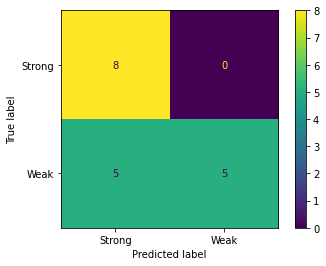

In [57]:
#RANDOM FOREST
model_RAN = RandomForestClassifier()
#train a baseline model
model_RAN_rfe = RFE(model_RAN, n_features_to_select=5)
model_RAN_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
RAN_extracted_features = X_train.columns[model_RAN_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
param_grid_RAN =  {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300,] } 

RAN_optimised = GridSearchCV(model_RAN, param_grid=param_grid_RAN,scoring='accuracy', cv=10)
RAN_optimised.fit(X_train, y_train.values.ravel())
model_RAN_optimised = RAN_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ran = []
precision_score_ran = []
recall_score_ran = []
f1_score_ran = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_RAN_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_RAN_optimised.predict(X_val)

        acc_ran = accuracy_score(pred, y_val)
        acc_score_ran.append(acc_ran)


        acc_ran = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ran.append(acc_ran)
        precision_score_ran.append(precision)
        recall_score_ran.append(recall)
        f1_score_ran.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_RAN_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('RANDOM Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_RAN_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

10 Features

In [58]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666667
0.605
0.6666666666666666
0.6053968253968254
Test Results
RANDOM Real result:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.40      0.57        10

    accuracy                           0.67        18
   macro avg       0.79      0.70      0.65        18
weighted avg       0.81      0.67      0.64        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


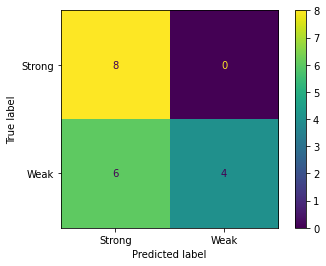

In [59]:
#RANDOM FOREST
model_RAN = RandomForestClassifier()
#train a baseline model
model_RAN_rfe = RFE(model_RAN, n_features_to_select=10)
model_RAN_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
RAN_extracted_features = X_train.columns[model_RAN_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
param_grid_RAN =  {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300,] } 

RAN_optimised = GridSearchCV(model_RAN, param_grid=param_grid_RAN,scoring='accuracy', cv=10)
RAN_optimised.fit(X_train, y_train.values.ravel())
model_RAN_optimised = RAN_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ran = []
precision_score_ran = []
recall_score_ran = []
f1_score_ran = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_RAN_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_RAN_optimised.predict(X_val)

        acc_ran = accuracy_score(pred, y_val)
        acc_score_ran.append(acc_ran)


        acc_ran = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ran.append(acc_ran)
        precision_score_ran.append(precision)
        recall_score_ran.append(recall)
        f1_score_ran.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_RAN_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('RANDOM Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_RAN_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

15 Features

In [60]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6571428571428571
0.6183333333333334
0.65
0.5954256854256854
Test Results
RANDOM Real result:  0.6111111111111112
              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.30      0.46        10

    accuracy                           0.61        18
   macro avg       0.77      0.65      0.58        18
weighted avg       0.79      0.61      0.57        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


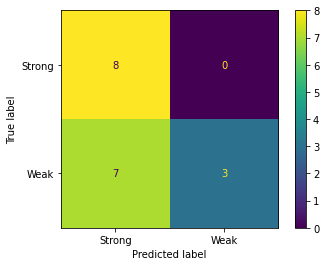

In [61]:
#RANDOM FOREST
model_RAN = RandomForestClassifier()
#train a baseline model
model_RAN_rfe = RFE(model_RAN, n_features_to_select=15)
model_RAN_rfe.fit(X_train, y_train.values.ravel())
#obtain the n feature
RAN_extracted_features = X_train.columns[model_RAN_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
param_grid_RAN =  {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300,] } 

RAN_optimised = GridSearchCV(model_RAN, param_grid=param_grid_RAN,scoring='accuracy', cv=10)
RAN_optimised.fit(X_train, y_train.values.ravel())
model_RAN_optimised = RAN_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()


#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ran = []
precision_score_ran = []
recall_score_ran = []
f1_score_ran = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_RAN_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_RAN_optimised.predict(X_val)

        acc_ran = accuracy_score(pred, y_val)
        acc_score_ran.append(acc_ran)


        acc_ran = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ran.append(acc_ran)
        precision_score_ran.append(precision)
        recall_score_ran.append(recall)
        f1_score_ran.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_RAN_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('RANDOM Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_RAN_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

#### ADABOOST 

5 Features

In [62]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results
0.6571428571428571
0.6183333333333334
0.65
0.5954256854256854
Test Results
ADABOOST Real result:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


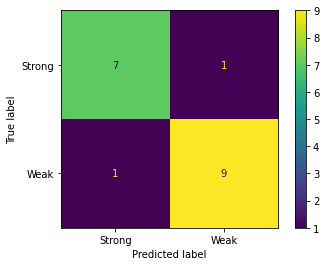

In [63]:
model_ADA = AdaBoostClassifier()

#ADABOOST

#train a baseline model
model_ADA_rfe = RFE(model_ADA, n_features_to_select=5)
model_ADA_rfe.fit(X_train, y_train.values.ravel())

#obtain the n feature
ADA_extracted_features = X_train.columns[model_ADA_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
grid_ADA =  {
        'n_estimators':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001]}

ADA_optimised = GridSearchCV(model_ADA, param_grid=grid_ADA,scoring='accuracy', cv=10)
ADA_optimised.fit(X_train, y_train.values.ravel())
model_ADA_optimised = ADA_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ada = []
precision_score_ada= []
recall_score_ada = []
f1_score_ada = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_ADA_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_ADA_optimised.predict(X_val)

        acc_ada = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ada.append(acc_ada)
        precision_score_ada.append(precision)
        recall_score_ada.append(recall)
        f1_score_ada.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_ADA_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('ADABOOST Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_ADA_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()


10 Features

In [64]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6571428571428571
0.6183333333333334
0.65
0.5954256854256854
Test Results
ADABOOST Real result:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


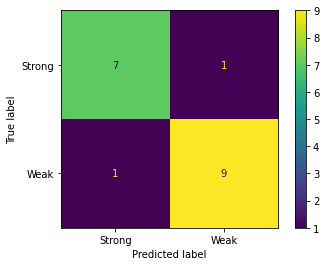

In [65]:
model_ADA = AdaBoostClassifier()

#ADABOOST

#train a baseline model
model_ADA_rfe = RFE(model_ADA, n_features_to_select=10)
model_ADA_rfe.fit(X_train, y_train.values.ravel())

#obtain the n feature
ADA_extracted_features = X_train.columns[model_ADA_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
grid_ADA =  {
        'n_estimators':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001]}

ADA_optimised = GridSearchCV(model_ADA, param_grid=grid_ADA,scoring='accuracy', cv=10)
ADA_optimised.fit(X_train, y_train.values.ravel())
model_ADA_optimised = ADA_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ada = []
precision_score_ada= []
recall_score_ada = []
f1_score_ada = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_ADA_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_ADA_optimised.predict(X_val)

        acc_ada = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ada.append(acc_ada)
        precision_score_ada.append(precision)
        recall_score_ada.append(recall)
        f1_score_ada.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_ADA_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('ADABOOST Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_ADA_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

15 Features

In [66]:
X = df_ml_dataset.drop(['label','label_encoded'],axis=1)
y = df_ml_dataset[['label_encoded']]
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

Training & Validation Results
0.6571428571428571
0.6183333333333334
0.65
0.5954256854256854
Test Results
ADABOOST Real result:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.90      0.90      0.90        10

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


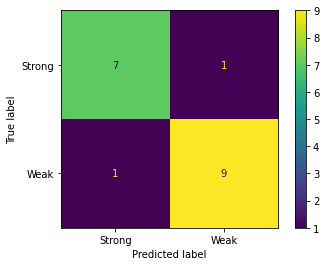

In [67]:
model_ADA = AdaBoostClassifier()

#ADABOOST

#train a baseline model
model_ADA_rfe = RFE(model_ADA, n_features_to_select=15)
model_ADA_rfe.fit(X_train, y_train.values.ravel())

#obtain the n feature
ADA_extracted_features = X_train.columns[model_ADA_rfe.support_]

#Obtain optimised hyperparameters
#Parameter Grid Setting
grid_ADA =  {
        'n_estimators':[100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001]}

ADA_optimised = GridSearchCV(model_ADA, param_grid=grid_ADA,scoring='accuracy', cv=10)
ADA_optimised.fit(X_train, y_train.values.ravel())
model_ADA_optimised = ADA_optimised.best_estimator_

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

#cross validate on training data
kf = KFold(n_splits=10, shuffle=True)
acc_score_ada = []
precision_score_ada= []
recall_score_ada = []
f1_score_ada = []

print ('Training & Validation Results')
for train_index, val_index in kf.split(X_train, y_train):
        X_trainsub, X_val = X_train[train_index], X_train[val_index]
        y_trainsub, y_val = y_train[train_index], y_train[val_index]

        model_ADA_optimised.fit(X_trainsub, y_trainsub.ravel())
        pred =  model_ADA_optimised.predict(X_val)

        acc_ada = accuracy_score(pred, y_val)
        precision = precision_score(pred, y_val)
        recall = recall_score(pred, y_val)
        f1 = f1_score(pred, y_val)


        acc_score_ada.append(acc_ada)
        precision_score_ada.append(precision)
        recall_score_ada.append(recall)
        f1_score_ada.append(f1)

print(np.mean(acc_score_ran))
print(np.mean(precision_score_ran))
print(np.mean(recall_score_ran))
print(np.mean(f1_score_ran))

#Evalaute model
print ('Test Results')
pred_test = model_ADA_optimised.predict (X_test)
acc_test = accuracy_score(pred_test, y_test)
print('ADABOOST Real result: ', acc_test)
print(classification_report(y_test, pred_test))
plot_confusion_matrix(model_ADA_optimised, X_test, y_test)
plt.xticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.yticks([0,1], ['Strong', 'Weak'], rotation=0)
plt.show()

# Explainability

In [ ]:
import shap
explainer = shap.TreeExplainer(model_XGB_optimised)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4, :])

In [ ]:
shap.initjs()
shap.dependence_plot('0_FFT mean coefficient_8', shap_values, X_train)

ValueError: Could not find feature named: 0_FFT mean coefficient_8

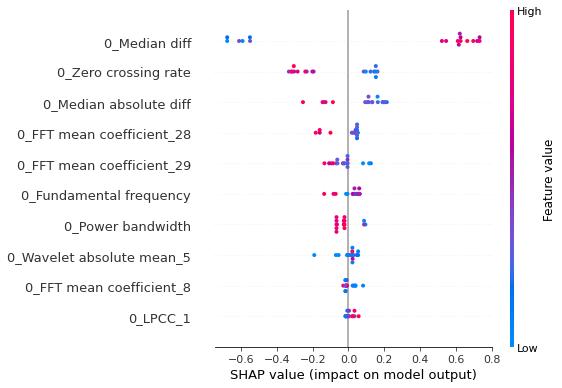

In [ ]:
shap.summary_plot(shap_values, X_test)

# Result Visualizations

Precision, Recall and F1 using 10 features - Training-validation set

<Figure size 1600x2240 with 0 Axes>

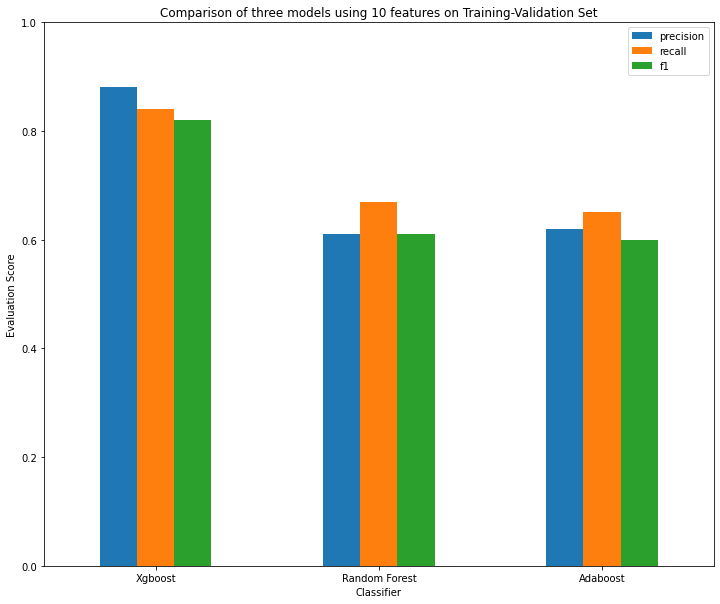

In [4]:
from turtle import color
%matplotlib inline

x = {'algorithm' : ['Xgboost','Random Forest', 'Adaboost'], 
    'precision':[0.88,0.61,0.62], 
    'recall':[0.84,0.67,0.65],
    'f1': [0.82,0.61,0.60],
    }

df = pd.DataFrame(x)

plt.figure(figsize=(10,14), dpi=160)
df.plot(x='algorithm', kind='bar', stacked=False, figsize=(12,10))
plt.ylim(0,1)
plt.xlabel('Classifier')
plt.xticks(rotation=0)
plt.ylabel('Evaluation Score')
plt.title('Comparison of three models using 10 features on Training-Validation Set')
plt.show()



Precision, Recall and F1 using 10 features - Test set

<Figure size 1600x2240 with 0 Axes>

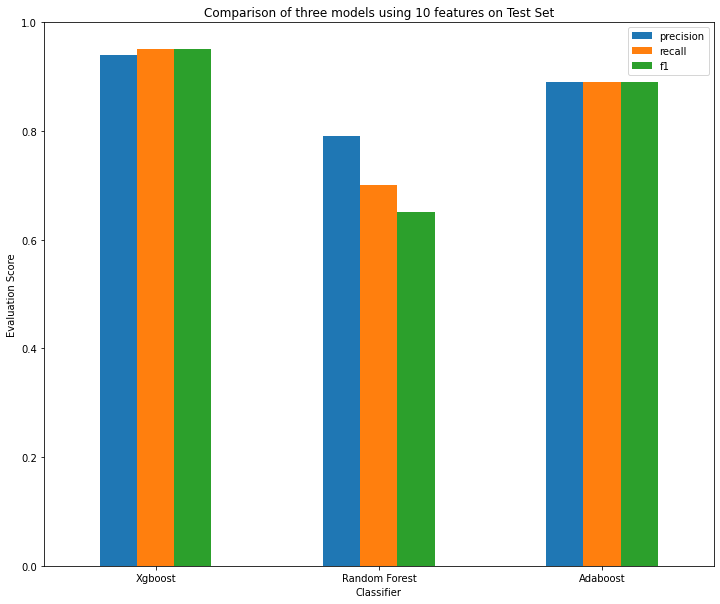

In [5]:
from turtle import color
%matplotlib inline

x = {'algorithm' : ['Xgboost','Random Forest', 'Adaboost'], 
    'precision':[0.94,0.79,0.89], 
    'recall':[0.95,0.70,0.89],
    'f1': [0.95,0.65,0.89],
    }

df = pd.DataFrame(x)

plt.figure(figsize=(10,14), dpi=160)
df.plot(x='algorithm', kind='bar', stacked=False, figsize=(12,10))
plt.ylim(0,1)
plt.xlabel('Classifier')
plt.xticks(rotation=0)
plt.ylabel('Evaluation Score')
plt.title('Comparison of three models using 10 features on Test Set')
plt.show()



<Figure size 1600x2240 with 0 Axes>

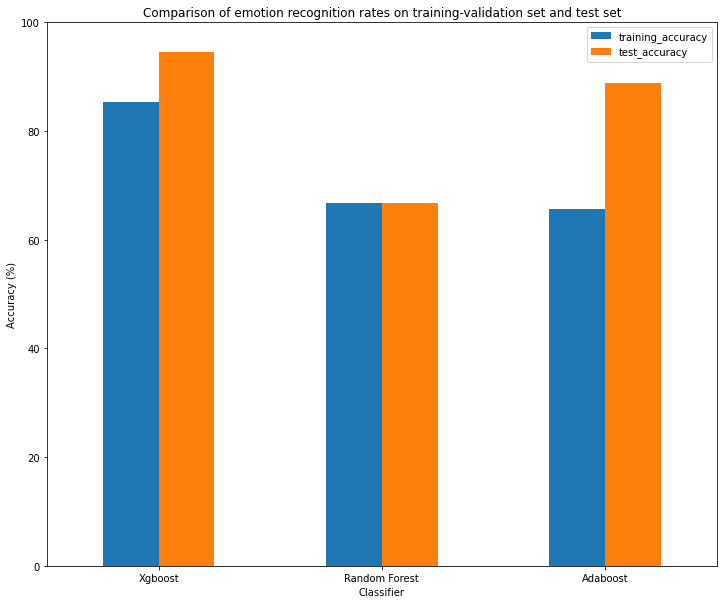

In [6]:
x = {'algorithm' : ['Xgboost','Random Forest', 'Adaboost'], 
    'training_accuracy':[85.23,66.66,65.71], 
    'test_accuracy':[94.44,66.67,88.88]
    }

df = pd.DataFrame(x)

plt.figure(figsize=(10,14), dpi=160)
df.plot(x='algorithm', kind='bar', stacked=False, figsize=(12,10))
plt.ylim(0,100)
plt.xlabel('Classifier')
plt.xticks(rotation=0)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of emotion recognition rates on training-validation set and test set')
plt.show()